I did not find the gold labels for the test set, so the only way to check your performance on the test set is to make a submission on the [Kaggle website](https://www.kaggle.com/c/nlp-getting-started/submit). 
I made a function to create a submission file from a prediction vector, *download_predictions_to_file()*, feel free to use it. Alternatively, you can just check your performance on a subset of the training set. 

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns


data_url = 'https://www.math.unipd.it/~dasan/disaster/'
train_csv = pd.read_csv(data_url + 'train.csv', sep=",") 
test_csv = pd.read_csv(data_url + 'test.csv', sep=",") 


In [3]:
def download_predictions_to_file(id_array, predictions_array):
  # This function, given a numpy array with the ids of the test tweets and a numpy array with the corresponding predictions, 
  # creates and let's you download a prediction file suitable to be uploaded to the Kaggle website

  id_array = id_array.reshape(len(id_array),1) # making sure the arrays are of the size requested by hstack(), i.e. (x,1) instead of (x,) 
  predictions_array = predictions_array.reshape(len(predictions_array),1)

  from google.colab import files
  result = pd.DataFrame(np.hstack((id_array, predictions_array)), columns=['id','target'])
  result.to_csv('prediction_file.csv', index=False)
  files.download('prediction_file.csv')


In [6]:
#let's take a look at the data
print(train_csv.head())
#print(train_csv.tail())
Y_train = train_csv["target"].values 
X_train = train_csv.values[:, 1:4] # extracting the columns keyword, location and text

#let's print one example to check we picked the right columns
print(X_train[0])

X_test_id = test_csv["id"].values # these are needed to build output prediction files if you want to submit your predictions to the Kaggle website (see format of the submission)

print(Y_train.shape, X_test_id.shape, X_train.shape)

# create a dummy pessimistic predictor that always says DISASTER (class 1) 
#test_predictions = np.ones((len(X_test_id),1), dtype=int)

#download_predictions_to_file(X_test_id, test_predictions) # download the prediction file


   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
[nan nan
 'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all']
(7613,) (3263,) (7613, 3)


In [5]:
print(X_train[0][2])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all


Class 0: 4342
Class 1: 3271


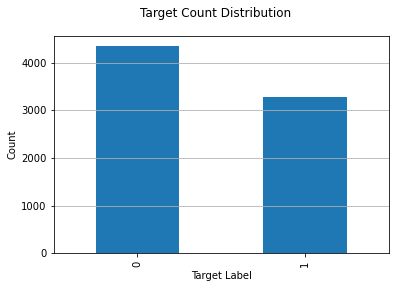

In [10]:
#Check data balance
"""Needed to check the skewness of the data which can negatively impact training and testing if highly unbalanced"""
from matplotlib import pyplot as plt 
print(f"Class 0: {np.sum(Y_train == 0)}")
print(f"Class 1: {np.sum(Y_train == 1)}")
ax = train_csv['target'].value_counts().plot(kind="bar")
ax.grid(axis="y")
ax.set_ylabel('Count')
ax.set_xlabel('Target Label')
plt.suptitle("Target Count Distribution")
plt.show()

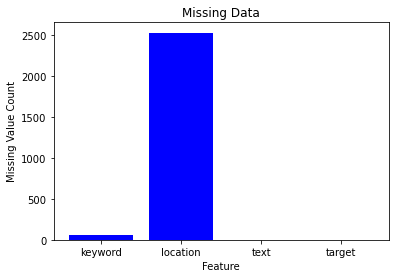

In [13]:
#Check for missing values
"""Needed to determine which columns can be appropriately used as features"""

missing_dict = {'keyword':train_csv['keyword'].isnull().sum(),
                'location':train_csv['location'].isnull().sum(),
                'text':train_csv['text'].isnull().sum(),
                'target':train_csv['target'].isnull().sum()}

features = list(missing_dict.keys())
values = list(missing_dict.values())

plt.bar(features, values, color ='blue',
        width = 0.8)
 
plt.xlabel("Feature")
plt.ylabel("Missing Value Count")
plt.title("Missing Data")
plt.show()

#print(missing_dict)


In [17]:
#Clean tweets and remove formatting
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize 
import re
from sklearn import model_selection, metrics, preprocessing, ensemble, model_selection, metrics



'''
stemming reduces extra characters from a word to its root or base of a word
tokenization breaks a phrase into smaller sections
vectorization maps words to real numbers

'''

# Clean columns
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

def tweet_clean(tweet_text):
  #remove url
  rmv_url = re.sub(r"http\S+", "",tweet_text  ) #S+ removes all non-whotespace characters at end of https
  #remove numbers
  rmv_num = re.sub(r'\d+', '',rmv_url) #d+ removes numbers in strings
  #tockenise 
  wrd_tocken = word_tokenize(rmv_num)
  #remove spatial character
  rmv_spc = []
  for wrd in wrd_tocken:
    rmv_spc.append("".join([e for e in wrd if e.isalnum()]))
  #remove stop words and convert to lower case
  rmv_stop_wrd = [w.lower() for w in rmv_spc if not w in stop_words]
  #implement stemming
  stemm_wrd = [stemmer.stem(w) for w in rmv_stop_wrd]

  return " ".join(" ".join(stemm_wrd).split()) ##Why do this?

train_csv['clean_text'] = train_csv['text'].apply(lambda x: tweet_clean(x) )
train_csv['keyword'] = train_csv['keyword'].fillna("none")
train_csv['clean_keyword'] = train_csv['keyword'].apply(lambda x: tweet_clean(x) )

# Merge'clean_keyword' and 'clean_text' columns ##Why are we mergibg this?
train_csv['keyword_text'] = train_csv['clean_keyword'] + " " + train_csv["clean_text"]
print(train_csv.head())

#Split Train and Test data
# split train and test
feature = 'keyword_text'
label = "target"
X_train, X_test,y_train, y_test = model_selection.train_test_split(train_csv[feature],
                                                                   train_csv[label],
                                                                   test_size=0.2,
                                                                   random_state=123, 
                                                                   shuffle=True)




[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/huzaifa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/huzaifa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


   id keyword location                                               text  \
0   1    none      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4    none      NaN             Forest fire near La Ronge Sask. Canada   
2   5    none      NaN  All residents asked to 'shelter in place' are ...   
3   6    none      NaN  13,000 people receive #wildfires evacuation or...   
4   7    none      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target                                         clean_text clean_keyword  \
0       1      our deed reason earthquak may allah forgiv us          none   
1       1               forest fire near la rong sask canada          none   
2       1  all resid ask shelter place notifi offic no ev...          none   
3       1        peopl receiv wildfir evacu order california          none   
4       1  just got sent photo rubi alaska smoke wildfir ...          none   

                                        keyword_text  
0  none our d

In [18]:

print(X_train.shape,X_test.shape ,y_train.shape, y_test.shape)
print(X_train[1])
print(X_test[6])
from sklearn.feature_extraction.text import CountVectorizer
# Vectorize text
vectorizer = CountVectorizer()
X_train_VCT = vectorizer.fit_transform(X_train)
x_test_VCT = vectorizer.transform(X_test)
print(X_train_VCT.shape)


(6090,) (1523,) (6090,) (1523,)
none forest fire near la rong sask canada
none flood disast heavi rain caus flash flood street manitou colorado spring area
(6090, 12121)


In [19]:
'''Classification model 1:
                          Logistic Regression'''
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

clf_lr = LogisticRegression()
clf_lr.fit(X_train_VCT, y_train)

#estimation (y_hat)
y_train_pred_lr = clf_lr.predict(X_train_VCT)
y_val_pred_lr = clf_lr.predict(x_test_VCT)
y_val_score_lr = clf_lr.predict_proba(x_test_VCT)[:,1]

print(f"Train ACC: {accuracy_score(y_train, y_train_pred_lr)}")
print(f"Val ACC: {accuracy_score(y_test, y_val_pred_lr)}")
print(f"(ROC) Train ACC: {roc_auc_score(y_train, y_train_pred_lr)}")
print(f"(ROC) Val ACC: {roc_auc_score(y_test, y_val_score_lr)}")

Train ACC: 0.9535303776683087
Val ACC: 0.8063033486539725
(ROC) Train ACC: 0.9491228772138023
(ROC) Val ACC: 0.8570262650244844


In [24]:
'''Logistic Regression with different C parameter values
''' ## in the report it says C=0.5 was the best, did we even try that?
C = [0.001, 0.01, 0.1, 1., 10, 100]
for c in C:
    clf_lr = LogisticRegression(C = c, max_iter = 200)
    clf_lr.fit(X_train_VCT, y_train)

    #estimation (y_hat)
    y_train_pred_lr = clf_lr.predict(X_train_VCT)
    y_val_pred_lr = clf_lr.predict(x_test_VCT)
    tr_acc = accuracy_score(y_train, y_train_pred_lr)
    val_acc= accuracy_score(y_test, y_val_pred_lr)

    print(f"LR. C= {c}.\tTrain ACC: {tr_acc}\tVal Acc: {val_acc}")

'''plot graph here'''

LR. C= 0.001.	Train ACC: 0.594088669950739	Val Acc: 0.5948785292186474
LR. C= 0.01.	Train ACC: 0.7909688013136289	Val Acc: 0.7550886408404465
LR. C= 0.1.	Train ACC: 0.8686371100164204	Val Acc: 0.8003939592908733
LR. C= 1.0.	Train ACC: 0.9533661740558292	Val Acc: 0.8056467498358503
LR. C= 10.	Train ACC: 0.987192118226601	Val Acc: 0.7839789888378201
LR. C= 100.	Train ACC: 0.9885057471264368	Val Acc: 0.7754432042022325


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


'plot graph here'

In [25]:
'''Logistic Regression with Grid search
'''
from sklearn.model_selection import GridSearchCV
#define the parameters grid
param_grid = {
    'C': [0.1, 0.5, 1, 5, 10, 15, 20],
    'fit_intercept': [True, False]
}

#target classifier
lr = LogisticRegression(max_iter= 200)

#grid-search object
clf = GridSearchCV(estimator= lr, param_grid=param_grid, cv = 10, scoring = "accuracy")

#fit the model
clf.fit(X_train_VCT, y_train)

#see the best parameters and performance
print(clf.best_params_)
print(clf.best_score_)

{'C': 0.5, 'fit_intercept': True}
0.7985221674876848


Accuracy:  0.8089297439264609
ROC:  0.7954479610511662
F1:  0.7581047381546134
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       879
           1       0.82      0.71      0.76       644

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523



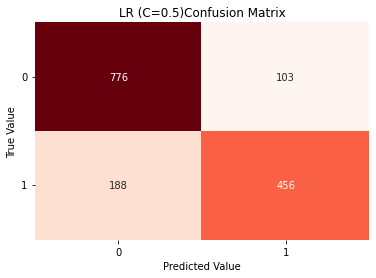

In [27]:
clf_lr = LogisticRegression(C = 0.5, max_iter = 200)
clf_lr.fit(X_train_VCT, y_train)
#estimation (y_hat)
y_train_pred_lr = clf_lr.predict(X_train_VCT)
y_val_pred_lr = clf_lr.predict(x_test_VCT)
tr_acc = accuracy_score(y_train, y_train_pred_lr)
val_acc= accuracy_score(y_test, y_val_pred_lr)


print("Accuracy: ",metrics.accuracy_score(y_test, y_val_pred_lr))
print("ROC: ",roc_auc_score(y_test, y_val_pred_lr))
print("F1: ",metrics.f1_score(y_test,y_val_pred_lr))
print(metrics.classification_report(y_test, y_val_pred_lr, target_names=["0", "1"]))

# Plot confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_val_pred_lr)

fig, ax = plt.subplots()
sns.heatmap(conf_matrix, cbar=False, cmap='Reds', annot=True, fmt='d')
ax.set(xlabel="Predicted Value", ylabel="True Value", title="LR (C=0.5)Confusion Matrix")
ax.set_yticklabels(labels=['0', '1'], rotation=0)

plt.show()


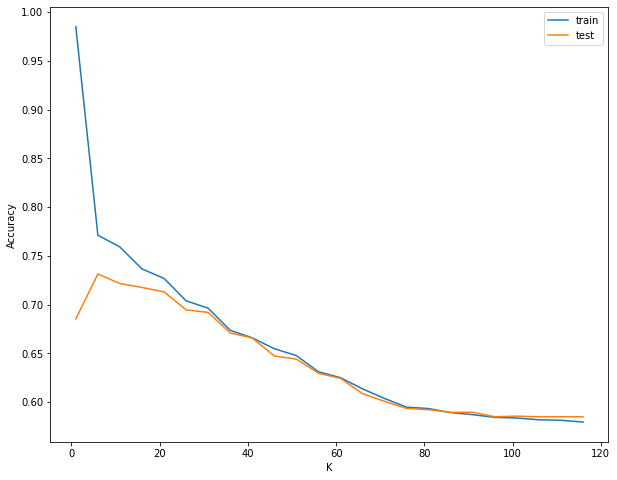

In [28]:
'''Classification model 2:
                          KNN'''
from sklearn.neighbors import KNeighborsClassifier
accuracy_values_train = []
accuracy_values_test = []
k_values = range(1, 120,5)

for k in k_values:
  model = KNeighborsClassifier(n_neighbors=k)
  model.fit(X_train_VCT, y_train)
  y_pred_train = model.predict(X_train_VCT)
  y_pred_test = model.predict(x_test_VCT)
  accuracy_values_train.append(accuracy_score(y_pred_train, y_train))
  accuracy_values_test.append(accuracy_score(y_pred_test, y_test))


fig = plt.figure(figsize=(10,8))
plt.plot(k_values, accuracy_values_train, label="train")
plt.plot(k_values, accuracy_values_test, label="test")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Accuracy:  0.7406434668417596
ROC:  0.7662743165228698
F1:  0.6332404828226555
              precision    recall  f1-score   support

           0       0.72      0.90      0.80       879
           1       0.79      0.53      0.63       644

    accuracy                           0.74      1523
   macro avg       0.75      0.71      0.72      1523
weighted avg       0.75      0.74      0.73      1523



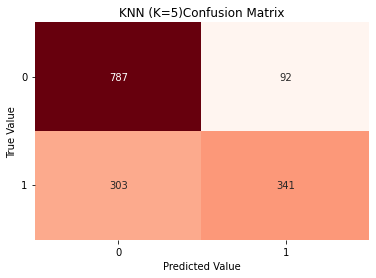

In [35]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train_VCT, y_train)
y_pred_train = model.predict(X_train_VCT)
y_pred_test = model.predict(x_test_VCT)
y_score = model.predict_proba(x_test_VCT)[:,1]

print("Accuracy: ",metrics.accuracy_score(y_pred_test, y_test))
print("ROC: ",roc_auc_score(y_true=y_test, y_score=y_score))
print("F1: ",metrics.f1_score(y_test, y_pred_test))
print(metrics.classification_report(y_test, y_pred_test, target_names=["0", "1"]))

# Plot confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred_test)

fig, ax = plt.subplots()
sns.heatmap(conf_matrix, cbar=False, cmap='Reds', annot=True, fmt='d')
ax.set(xlabel="Predicted Value", ylabel="True Value", title="KNN (K=5)Confusion Matrix")
ax.set_yticklabels(labels=['0', '1'], rotation=0)

plt.show()

Accuracy:  0.7557452396585687
ROC:  0.8368134314120365
F1:  0.6402321083172148
{'criterion': 'entropy', 'max_depth': 64, 'max_features': 'auto'}
              precision    recall  f1-score   support

           0       0.72      0.93      0.82       879
           1       0.85      0.51      0.64       644

    accuracy                           0.76      1523
   macro avg       0.79      0.72      0.73      1523
weighted avg       0.78      0.76      0.74      1523



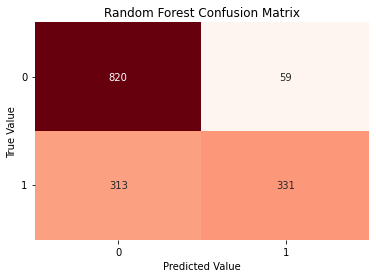

In [37]:
'''Classification model 3:
                          Random Forest'''
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score,  precision_score, roc_curve

param_grid = {
    'max_features': ['auto', 'log2', None],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,4,8,16,32,64]
    }
dtc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, scoring='roc_auc', n_jobs=-1)
dtc.fit(X_train_VCT, y_train)
y_pred = dtc.predict(x_test_VCT)
y_score = dtc.predict_proba(x_test_VCT)[:,1]

print("Accuracy: ",accuracy_score(y_true=y_test, y_pred=y_pred))
print("ROC: ",roc_auc_score(y_true=y_test, y_score=y_score))
print("F1: ",metrics.f1_score(y_test, y_pred))
print(dtc.best_params_)
print(metrics.classification_report(y_test, y_pred, target_names=["0", "1"]))

# Plot confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots()
sns.heatmap(conf_matrix, cbar=False, cmap='Reds', annot=True, fmt='d')
ax.set(xlabel="Predicted Value", ylabel="True Value", title="Random Forest Confusion Matrix")
ax.set_yticklabels(labels=['0', '1'], rotation=0)

plt.show()


Accuracy:  0.8023637557452397
ROC:  0.8588034115560454
F1:  0.7389418907198612
              precision    recall  f1-score   support

           0       0.79      0.91      0.84       879
           1       0.84      0.66      0.74       644

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.79      1523
weighted avg       0.81      0.80      0.80      1523



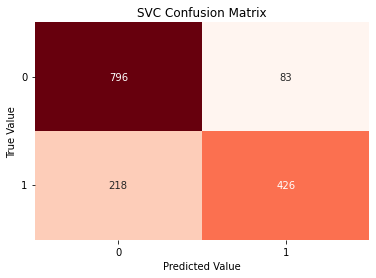

In [21]:
'''Classification model 4:
                          SVC'''
from sklearn.svm import SVC
svc = SVC(probability=True)  #why put probability=True?
svc.fit(X_train_VCT, y_train)
y_pred = svc.predict(x_test_VCT)
y_score = svc.predict_proba(x_test_VCT)[:,1]
print("Accuracy: ",accuracy_score(y_true=y_test, y_pred=y_pred))
print("ROC: ",roc_auc_score(y_true=y_test, y_score=y_score))
print("F1: ",metrics.f1_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred, target_names=["0", "1"]))
# Plot confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots()
sns.heatmap(conf_matrix, cbar=False, cmap='Reds', annot=True, fmt='d')
ax.set(xlabel="Predicted Value", ylabel="True Value", title="SVC Confusion Matrix")
ax.set_yticklabels(labels=['0', '1'], rotation=0)

plt.show()

Accuracy:  0.7984241628365069
ROC:  0.8496694790098857
F1:  0.7387234042553191
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       879
           1       0.82      0.67      0.74       644

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523



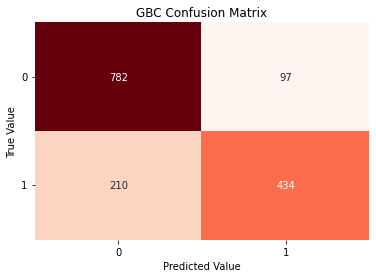

In [39]:
'''Classification model 5:
                          Gradient Boosting Classifier'''

from sklearn.ensemble import GradientBoostingClassifier

model = ensemble.GradientBoostingClassifier(learning_rate=0.1,                                            
                                            n_estimators=2000,
                                            max_depth=9,
                                            min_samples_split=6,
                                            min_samples_leaf=2,
                                            max_features=8,
                                            subsample=0.9)
model.fit(X_train_VCT, y_train)
y_score = model.predict_proba(x_test_VCT)[:,1]
predicted = model.predict(x_test_VCT)

accuracy = metrics.accuracy_score(predicted, y_test)
print("Accuracy: ",metrics.accuracy_score(predicted, y_test))
print("ROC: ",roc_auc_score(y_true=y_test, y_score=y_score))
print("F1: ",metrics.f1_score(y_test, predicted))

print(metrics.classification_report(y_test, predicted, target_names=["0", "1"]))

# Plot confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, predicted)

fig, ax = plt.subplots()
sns.heatmap(conf_matrix, cbar=False, cmap='Reds', annot=True, fmt='d')
ax.set(xlabel="Predicted Value", ylabel="True Value", title="GBC Confusion Matrix")
ax.set_yticklabels(labels=['0', '1'], rotation=0)

plt.show()

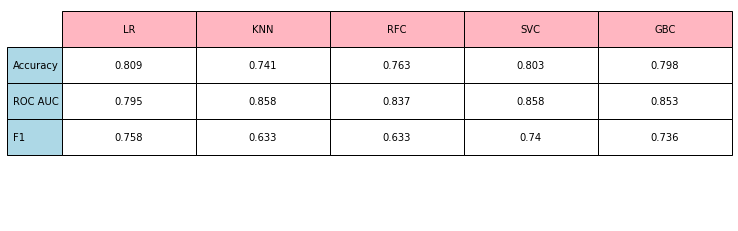

In [40]:
accuracies = [0.8089297439264609,0.7406434668417596,0.762967826657912,0.8030203545633617,0.7984241628365069]
rocs = [0.7954479610511662,0.8584907326931366,0.8374114076555091,0.8584907326931366,0.8533703954945979]
f_1 = [0.7581047381546134,0.6332404828226555,0.6332404828226555,0.7395833333333334,0.7364806866952789]
fig, ax = plt.subplots()
ax.set_axis_off()
table = ax.table(
    cellText=np.round([accuracies,rocs,f_1],decimals=3),
    colLabels=["LR", "KNN", "RFC", "SVC", "GBC"],
    rowLabels=['Accuracy','ROC AUC','F1'],
    cellLoc='center',
    loc='upper center',
    rowColours=['lightblue']*4,
    colColours=['lightpink']*5
)
table.scale(2,3)